# DANDI:001335 - Neuropixels Recordings from Mouse Hippocampus during Odor Presentation

**⚠️ IMPORTANT: This notebook was AI-generated with human supervision and has not been fully verified. Please be cautious when interpreting the code or results.**

This notebook provides an introduction to the DANDI:001335 dataset, which contains Neuropixels recordings from the hippocampus of head-fixed mice during odor presentation experiments. We'll explore the dataset structure and demonstrate how to load and analyze the neural data.

## Dataset Overview

This experiment recorded neural activity from the hippocampus while presenting different odor sequences to head-fixed mice. Here are the key details:

* **Subject**: Wild-type mouse (M541), age P8W
* **Recording**: Neuropixels probe in dorsal CA1
* **Task Structure**: Block structure with different odor sequences:
  * Block 1: Odors A, B, C presented in sequence
  * Block 2: Odors D, E, F presented in sequence
  * Block 3: All odors (A-F) presented for localization

Let's start by loading the data and examining its structure.

In [1]:
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt

# The dataset is hosted on DANDI. We'll use lindi to efficiently access it
print("Loading NWB file...")
f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/001335/assets/aca66db7-4c02-4453-8dcb-a179d44b1c5d/nwb.lindi.json")
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

Loading NWB file...


## Experimental Design

Let's examine the timing of odor presentations to understand the experimental structure.

Odor presentation summary:

Odor A:
Number of presentations: 101
Average duration: 2.00 seconds
First presentation at: 645.08 seconds
Last presentation at: 6166.19 seconds

Odor B:
Number of presentations: 101
Average duration: 2.00 seconds
First presentation at: 627.42 seconds
Last presentation at: 6112.42 seconds

Odor C:
Number of presentations: 101
Average duration: 2.00 seconds
First presentation at: 621.84 seconds
Last presentation at: 6145.06 seconds

Odor D:
Number of presentations: 101
Average duration: 2.00 seconds
First presentation at: 2717.42 seconds
Last presentation at: 6100.93 seconds

Odor E:
Number of presentations: 101
Average duration: 2.00 seconds
First presentation at: 2724.06 seconds
Last presentation at: 6156.08 seconds

Odor F:
Number of presentations: 101
Average duration: 2.00 seconds
First presentation at: 2729.77 seconds
Last presentation at: 6001.61 seconds


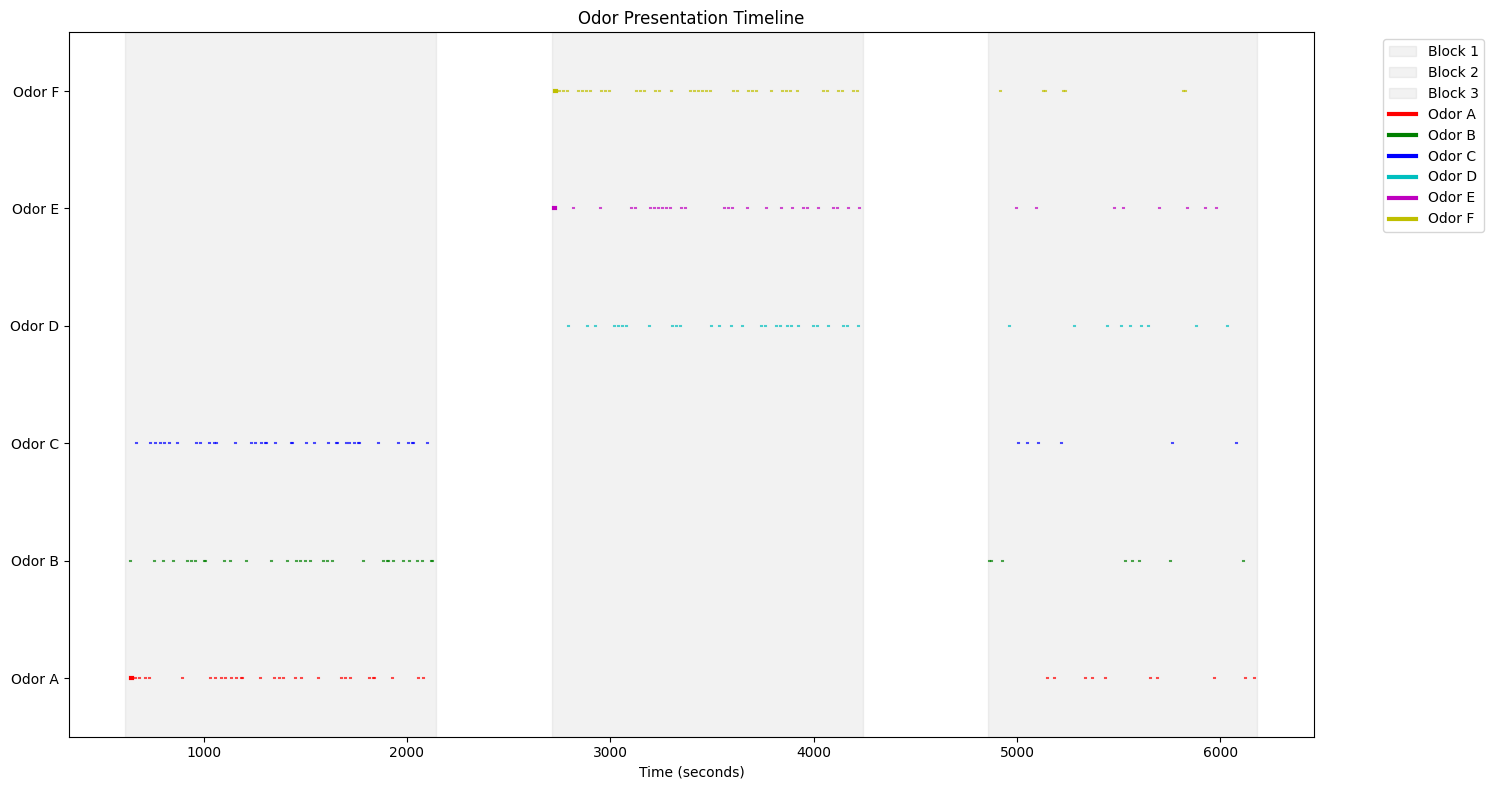

In [2]:
# Get timing information for each odor
odors = ['A', 'B', 'C', 'D', 'E', 'F']
print("Odor presentation summary:")
for odor in odors:
    odor_intervals = nwb.intervals[f"Odor {odor} ON"]
    start_times = odor_intervals["start_time"].data[:]
    stop_times = odor_intervals["stop_time"].data[:]
    durations = stop_times - start_times
    
    print(f"\nOdor {odor}:")
    print(f"Number of presentations: {len(start_times)}")
    print(f"Average duration: {np.mean(durations):.2f} seconds")
    print(f"First presentation at: {start_times[0]:.2f} seconds")
    print(f"Last presentation at: {start_times[-1]:.2f} seconds")

# Plot odor presentation timeline with blocks
plt.figure(figsize=(15, 8))
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# First plot the block intervals
block_names = ['Block 1', 'Block 2', 'Block 3']
for block_num in [1, 2, 3]:
    block = nwb.intervals[f"Block {block_num}"]
    start = float(block["start_time"].data[:][0])  # Convert to scalar
    end = float(block["stop_time"].data[:][0])  # Convert to scalar
    plt.axvspan(start, end, color='gray', alpha=0.1, label=f'Block {block_num}')

# Then plot all odor presentations
for i, odor in enumerate(odors):
    odor_intervals = nwb.intervals[f"Odor {odor} ON"]
    starts = odor_intervals["start_time"].data[:]
    durations = odor_intervals["stop_time"].data[:] - starts
    
    # Plot all presentations
    for start, duration in zip(starts, durations):
        plt.plot([start, start + duration], [i, i], 
                 color=colors[i], linewidth=1.5, alpha=0.7)
    # Add a thicker line for the first presentation to show in legend
    plt.plot([starts[0], starts[0] + durations[0]], [i, i],
             color=colors[i], linewidth=3, label=f'Odor {odor}')

plt.ylim(-0.5, len(odors)-0.5)
plt.yticks(range(len(odors)), [f'Odor {o}' for o in odors])
plt.xlabel('Time (seconds)')
plt.title('Odor Presentation Timeline')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

As we can see above:
* Each odor is presented 101 times total
* Each presentation lasts exactly 2 seconds
* Blocks 1 and 2 contain different odor sequences:
  * Block 1 (~600-2700s): Odors A, B, C presented in sequence 
  * Block 2 (~2700-6200s): Odors D, E, F presented in sequence
* Block 3 includes presentations of all odors (A-F) for localization purposes

## Neural Data Overview

The dataset contains two main types of neural data:
1. Spike times from 283 sorted units
2. LFP recordings from 64 channels

Let's first look at the recording locations:

In [3]:
# Print electrode information
electrodes = nwb.ec_electrodes
print("Recording locations:")
unique_locations = np.unique(electrodes["location"].data[:])
for loc in unique_locations:
    n_electrodes = np.sum(electrodes["location"].data[:] == loc)
    print(f"{loc}: {n_electrodes} electrodes")

print("\nDepth range:")
depths = electrodes["depth"].data[:]
print(f"Min depth: {np.min(depths):.1f}")
print(f"Max depth: {np.max(depths):.1f}")

Recording locations:
brain area: 64 electrodes

Depth range:
Min depth: 1460.0
Max depth: 2390.0


## Example Analyses

Let's demonstrate some basic analyses you might want to perform with this data.
We'll focus on neural responses to odor presentations.

### 1. Spike Raster Plot

First, let's look at spiking activity around odor presentations:

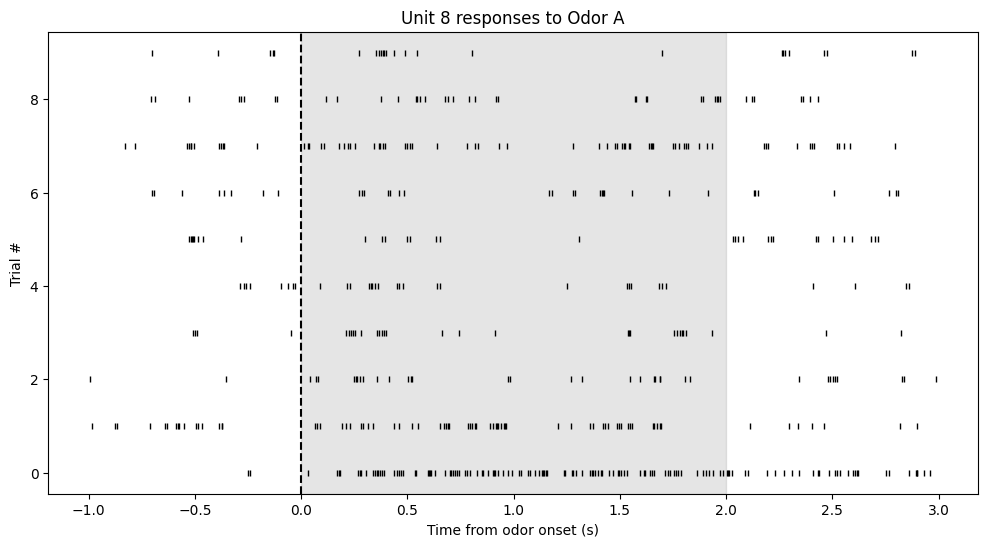

In [4]:
def plot_raster_around_event(spike_times, event_times, window=[-1, 3], n_events=10):
    """Plot spike raster aligned to events"""
    spikes_aligned = []
    for event_time in event_times[:n_events]:
        mask = (spike_times >= event_time + window[0]) & (spike_times <= event_time + window[1])
        spikes_aligned.append(spike_times[mask] - event_time)
    
    plt.figure(figsize=(12, 6))
    for i, spikes in enumerate(spikes_aligned):
        plt.plot(spikes, np.ones_like(spikes) * i, '|', color='black', markersize=4)
    
    plt.axvspan(0, 2, color='gray', alpha=0.2)
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel('Time from odor onset (s)')
    plt.ylabel('Trial #')
    return plt.gca()

# Get example unit and odor
unit_id = 8  # One of the responsive units we found
odor = 'A'
spike_times = nwb.units["spike_times"][unit_id]
odor_starts = nwb.intervals[f"Odor {odor} ON"]["start_time"].data[:]

# Plot raster
ax = plot_raster_around_event(spike_times, odor_starts)
plt.title(f'Unit {unit_id} responses to Odor {odor}')
plt.show()

### 2. Peri-Stimulus Time Histogram (PSTH)

Now let's compute the average firing rate around odor onset:

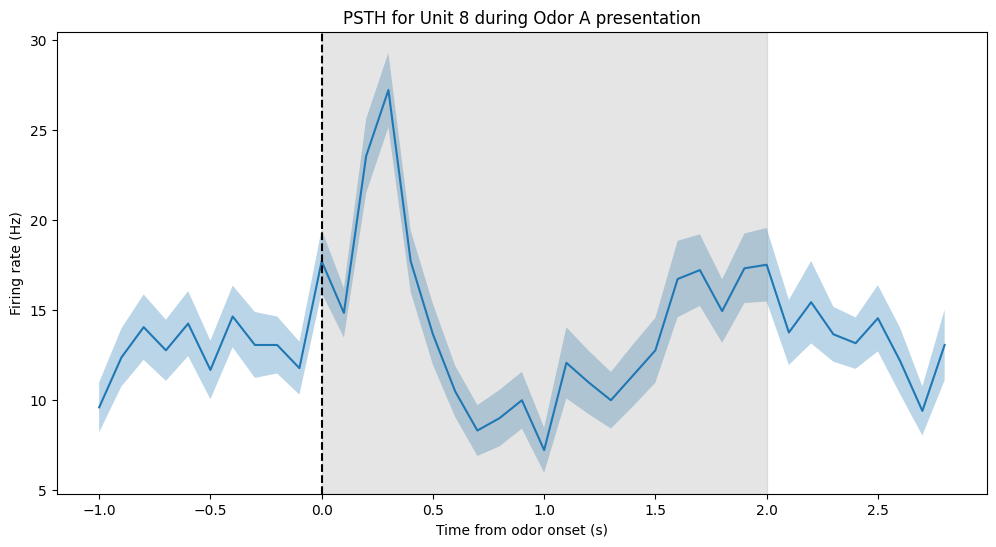

In [5]:
def compute_psth(spike_times, event_times, window=[-1, 3], bin_size=0.1):
    """Compute PSTH aligned to events"""
    bins = np.arange(window[0], window[1], bin_size)
    counts = np.zeros((len(event_times), len(bins)-1))
    
    for i, event_time in enumerate(event_times):
        mask = (spike_times >= event_time + window[0]) & (spike_times <= event_time + window[1])
        aligned_spikes = spike_times[mask] - event_time
        counts[i], _ = np.histogram(aligned_spikes, bins=bins)
    
    rate = np.mean(counts, axis=0) / bin_size  # Convert to Hz
    sem = np.std(counts, axis=0) / np.sqrt(len(event_times)) / bin_size
    return bins[:-1], rate, sem

# Compute PSTH
bins, rate, sem = compute_psth(spike_times, odor_starts)

# Plot
plt.figure(figsize=(12, 6))
plt.fill_between(bins, rate-sem, rate+sem, alpha=0.3)
plt.plot(bins, rate)
plt.axvspan(0, 2, color='gray', alpha=0.2)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('Time from odor onset (s)')
plt.ylabel('Firing rate (Hz)')
plt.title(f'PSTH for Unit {unit_id} during Odor {odor} presentation')
plt.show()

### 3. LFP Analysis

Finally, let's look at the LFP signal around odor presentations:

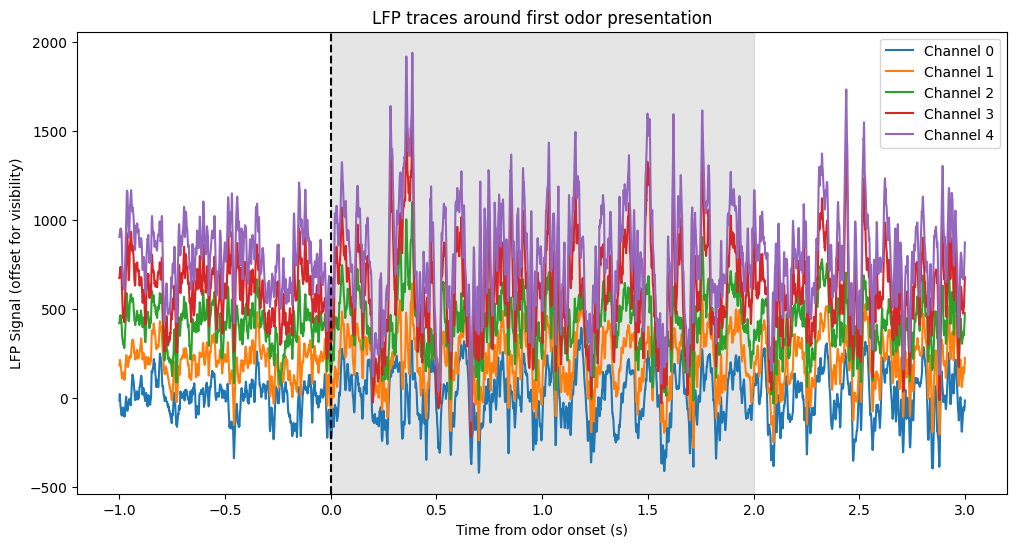

In [6]:
def plot_lfp_around_event(lfp, event_time, window=[-1, 3], n_channels=5):
    """Plot LFP traces around an event"""
    sample_rate = lfp.rate
    pre_samples = int(-window[0] * sample_rate)
    post_samples = int(window[1] * sample_rate)
    total_samples = pre_samples + post_samples
    
    start_idx = int(event_time * sample_rate) - pre_samples
    end_idx = start_idx + total_samples
    
    try:
        lfp_snippet = lfp.data[start_idx:end_idx, :n_channels]
        time = np.linspace(window[0], window[1], total_samples)
        
        plt.figure(figsize=(12, 6))
        for i in range(n_channels):
            plt.plot(time, lfp_snippet[:, i] + i*200, label=f'Channel {i}')
            
        plt.axvspan(0, 2, color='gray', alpha=0.2)
        plt.axvline(0, color='k', linestyle='--')
        plt.xlabel('Time from odor onset (s)')
        plt.ylabel('LFP Signal (offset for visibility)')
        plt.legend()
        return True
    except Exception as e:
        print(f"Error loading LFP data: {e}")
        return False

# Plot LFP around first odor presentation
lfp = nwb.processing["ecephys"]["LFP"]
success = plot_lfp_around_event(lfp, odor_starts[0])
if success:
    plt.title('LFP traces around first odor presentation')
    plt.show()

## Example Research Questions

This dataset could be used to investigate several interesting questions:

1. **Odor Selectivity**: Do hippocampal neurons show selective responses to different odors? You could compare PSTHs across different odors for the same neuron.

2. **Learning Effects**: Does neural activity change over the course of repeated presentations? You could analyze how responses evolve from early to late trials.

3. **Population Dynamics**: How does the population activity encode odor identity? You could use dimensionality reduction techniques on population responses.

4. **LFP-Spike Relationships**: Is there a relationship between LFP oscillations and spike timing during odor processing? You could analyze spike-LFP phase relationships.

Here's a simple example examining response consistency across trials:

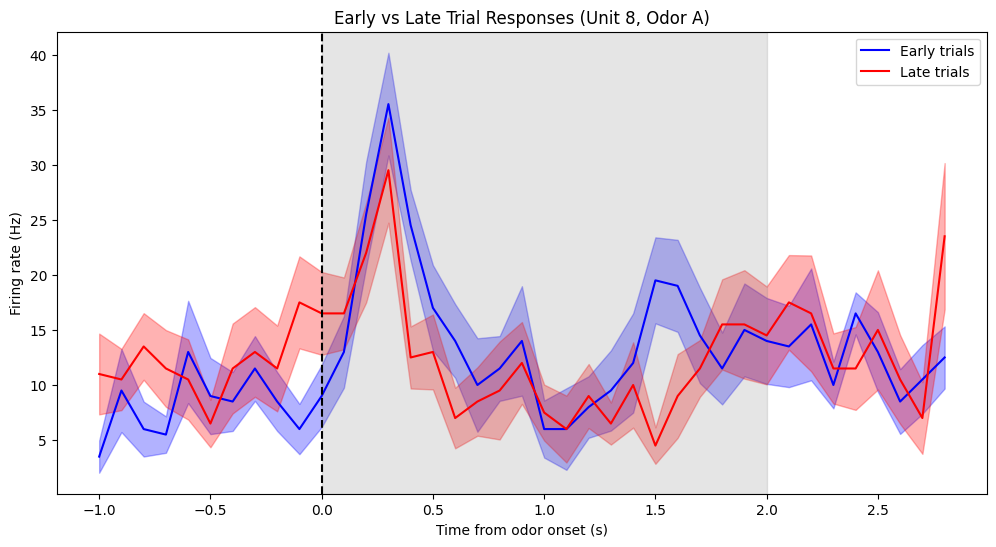

In [7]:
# Compare early vs late responses for our example unit
early_trials = odor_starts[:20]  # First 20 presentations
late_trials = odor_starts[-20:]  # Last 20 presentations

# Compute PSTHs
bins_early, rate_early, sem_early = compute_psth(spike_times, early_trials)
bins_late, rate_late, sem_late = compute_psth(spike_times, late_trials)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.fill_between(bins_early, rate_early-sem_early, rate_early+sem_early, alpha=0.3, color='blue')
plt.plot(bins_early, rate_early, color='blue', label='Early trials')
plt.fill_between(bins_late, rate_late-sem_late, rate_late+sem_late, alpha=0.3, color='red')
plt.plot(bins_late, rate_late, color='red', label='Late trials')

plt.axvspan(0, 2, color='gray', alpha=0.2)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('Time from odor onset (s)')
plt.ylabel('Firing rate (Hz)')
plt.title(f'Early vs Late Trial Responses (Unit {unit_id}, Odor {odor})')
plt.legend()
plt.show()

## Additional Resources

- View this dataset on DANDI: [DANDI:001335](https://dandiarchive.org/dandiset/001335)
- Documentation for key libraries:
  - [lindi](https://github.com/flatironinstitute/lindi): Efficient remote data access
  - [pynwb](https://pynwb.readthedocs.io/): Working with NWB files

For questions about the dataset, please contact the contributors:
- Manish Mohapatra
- Yaroslav Halchenko